In [2]:
pip install tensorflow

In [3]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.0 MB/s eta 0:00:00


In [4]:
pip install torch torchvision

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
from scipy.special import softmax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import csv
import urllib.request
import torch.nn.functional as F


In [10]:
# Load the predicted ages dataset
predicted_data = pd.read_csv('/content/predicted_ages.csv')

# Preprocess your text (if needed)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Load sentiment analysis model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [12]:
# Load the predicted ages dataset
predicted_data = pd.read_csv('predicted_ages.csv')

# Preprocess your text for sentiment analysis
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Preprocess text in predicted_data
predicted_data["Text"] = predicted_data["Text"].apply(preprocess)

# Load sentiment analysis model and tokenizer
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Set the max_length parameter for the tokenizer
max_length = 512  # You can adjust this value based on your needs

# Tokenize your text in batches
batch_size = 8  # Adjust the batch size as needed
num_samples = len(predicted_data)
num_batches = (num_samples + batch_size - 1) // batch_size

# Make predictions
scores_list = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples)

    batch_texts = predicted_data["Text"][start_idx:end_idx]
    batch_encoded_inputs = tokenizer(
        batch_texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,  # Set the max_length here
        return_tensors='pt',
    )

    # Ensure token_type_ids is included even if not used by the model
    batch_encoded_inputs["token_type_ids"] = torch.zeros_like(batch_encoded_inputs["input_ids"])

    # Make sure to move the tensor to the same device as the model
    batch_encoded_inputs = {k: v.to(model.device) for k, v in batch_encoded_inputs.items()}

    with torch.no_grad():
        batch_output = model(**batch_encoded_inputs)
    batch_scores = batch_output.logits
    scores_list.append(batch_scores)

# Concatenate scores from all batches
scores = torch.cat(scores_list, dim=0)

# Softmax to get sentiment probabilities
scores = F.softmax(scores, dim=1)





In [ ]:
max_text_length = max(predicted_data["Text"].apply(lambda x: len(tokenizer.tokenize(x))))
print("Maximum text length:", max_text_length)


Maximum text length: 10316


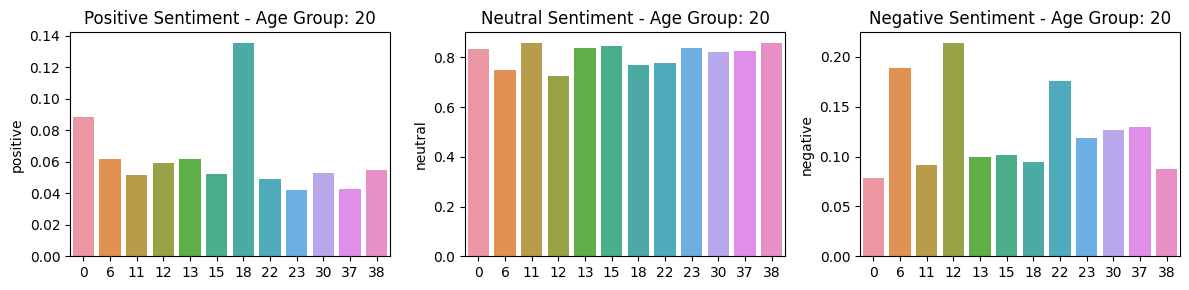

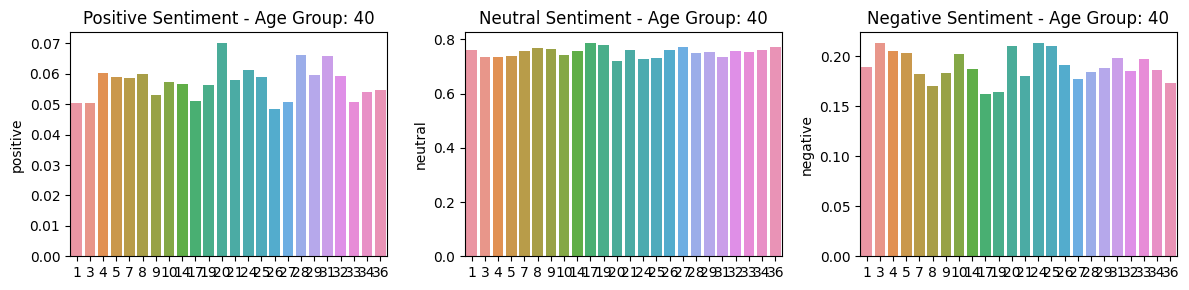

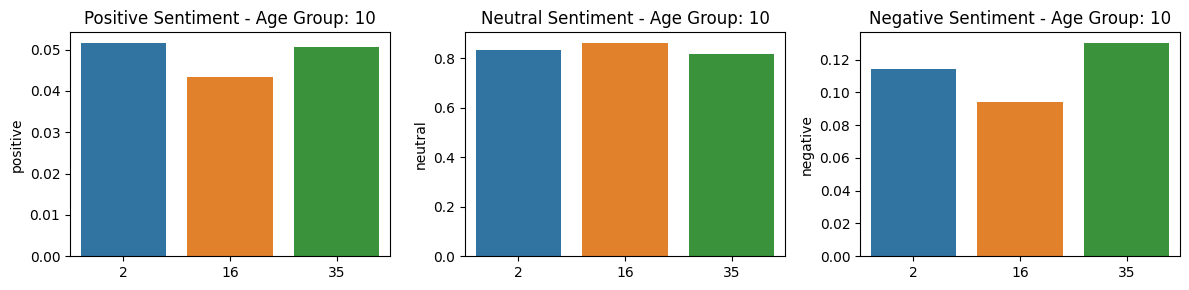

In [ ]:
# Visualize sentiment scores for each age group
def visualize_sentiment_scores_age_group(df, scores, labels, age_groups):
    # Create a DataFrame to store the sentiment scores and labels
    sentiment_df = pd.DataFrame(scores, columns=labels)
    sentiment_df["Text"] = df["Text"].tolist()
    sentiment_df["predicted_age"] = df["predicted_age"].tolist()

    # Plot sentiment scores for each age group
    unique_age_groups = df["predicted_age"].unique()
    for age_group in unique_age_groups:
        age_group_df = sentiment_df[sentiment_df["predicted_age"] == age_group]
        age_group_scores = age_group_df[labels].values

        # Create subplots for positive, neutral, and negative sentiment scores
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))

        # Plot positive sentiment scores
        sns.barplot(data=age_group_df, x=age_group_df.index, y='positive', ax=axs[0])
        axs[0].set_title(f'Positive Sentiment - Age Group: {age_group}')

        # Plot neutral sentiment scores
        sns.barplot(data=age_group_df, x=age_group_df.index, y='neutral', ax=axs[1])
        axs[1].set_title(f'Neutral Sentiment - Age Group: {age_group}')

        # Plot negative sentiment scores
        sns.barplot(data=age_group_df, x=age_group_df.index, y='negative', ax=axs[2])
        axs[2].set_title(f'Negative Sentiment - Age Group: {age_group}')

        plt.tight_layout()
        plt.show()

# Calculate unique age groups
unique_age_groups = predicted_data["predicted_age"].unique()

# Call the function to visualize sentiment scores for each age group
visualize_sentiment_scores_age_group(predicted_data, scores, labels, unique_age_groups)


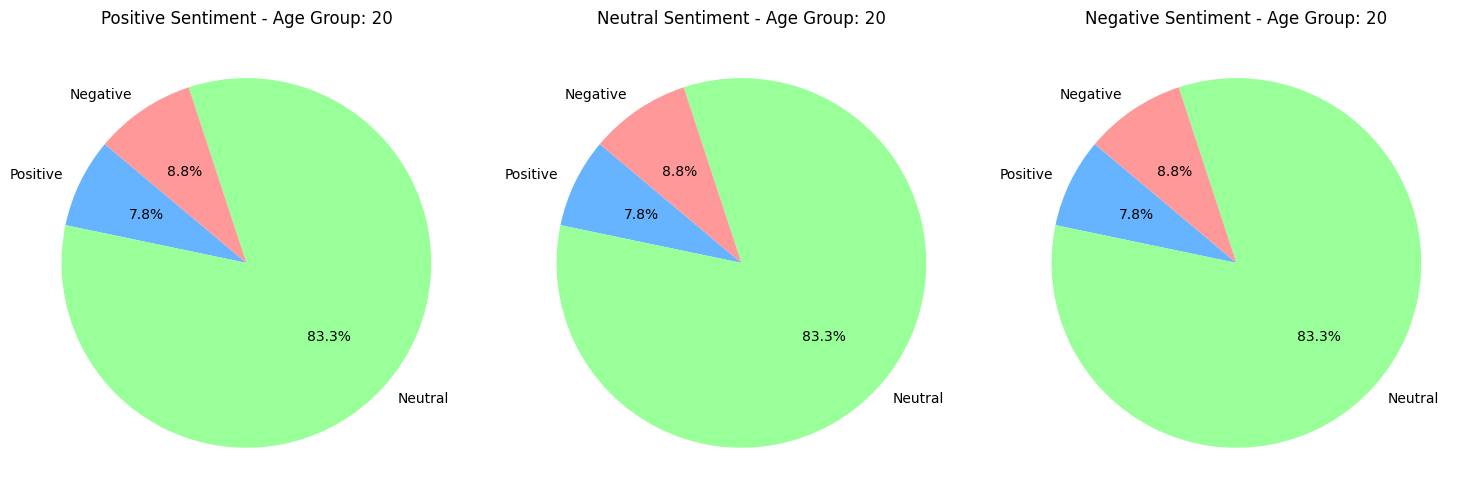

KeyError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize sentiment scores for each age group
def visualize_sentiment_scores_age_group(df, scores, labels, age_groups):
    # Create a DataFrame to store the sentiment scores and labels
    sentiment_df = pd.DataFrame(scores, columns=labels)
    sentiment_df["Text"] = df["Text"].tolist()
    sentiment_df["predicted_age"] = df["predicted_age"].tolist()

    # Plot sentiment scores for each age group
    unique_age_groups = df["predicted_age"].unique()
    for age_group in unique_age_groups:
        age_group_df = sentiment_df[sentiment_df["predicted_age"] == age_group]
        age_group_scores = age_group_df[labels].values[0]  # Assuming only one row per age group

        # Create subplots for positive, neutral, and negative sentiment scores
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        colors = ['#66b3ff', '#99ff99', '#ff9999']
        labels = ['Positive', 'Neutral', 'Negative']

        # Plot positive sentiment scores
        axs[0].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[0].set_title(f'Positive Sentiment - Age Group: {age_group}')

        # Plot neutral sentiment scores
        axs[1].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[1].set_title(f'Neutral Sentiment - Age Group: {age_group}')

        # Plot negative sentiment scores
        axs[2].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[2].set_title(f'Negative Sentiment - Age Group: {age_group}')

        plt.tight_layout()
        plt.show()

# Calculate unique age groups
unique_age_groups = predicted_data["predicted_age"].unique()

# Call the function to visualize sentiment scores for each age group
visualize_sentiment_scores_age_group(predicted_data, scores, labels, unique_age_groups)


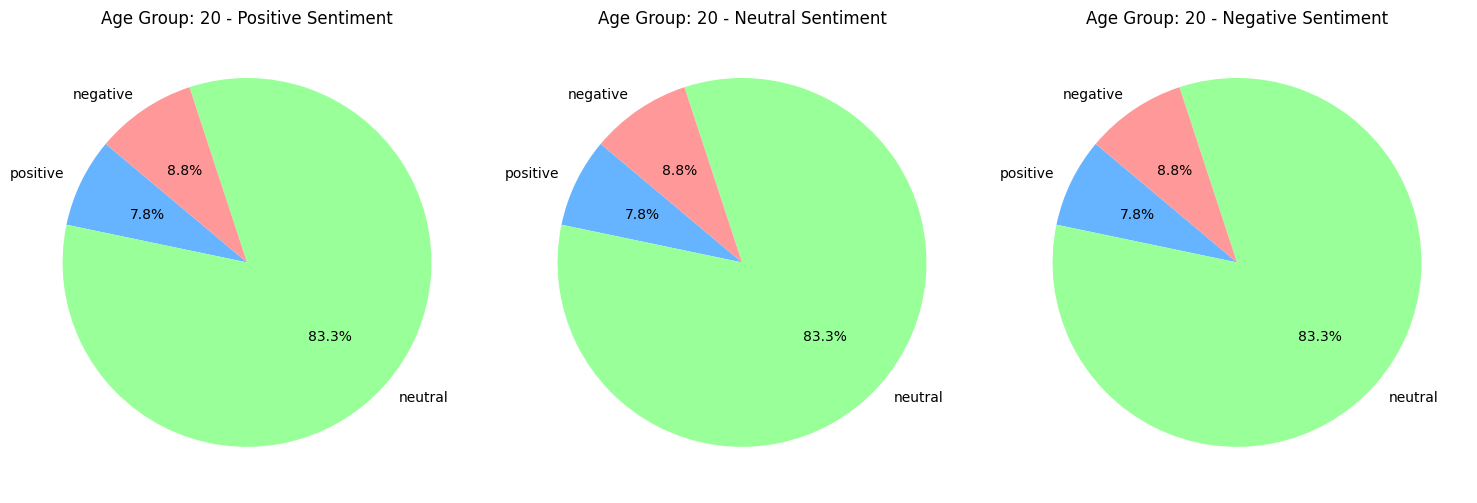

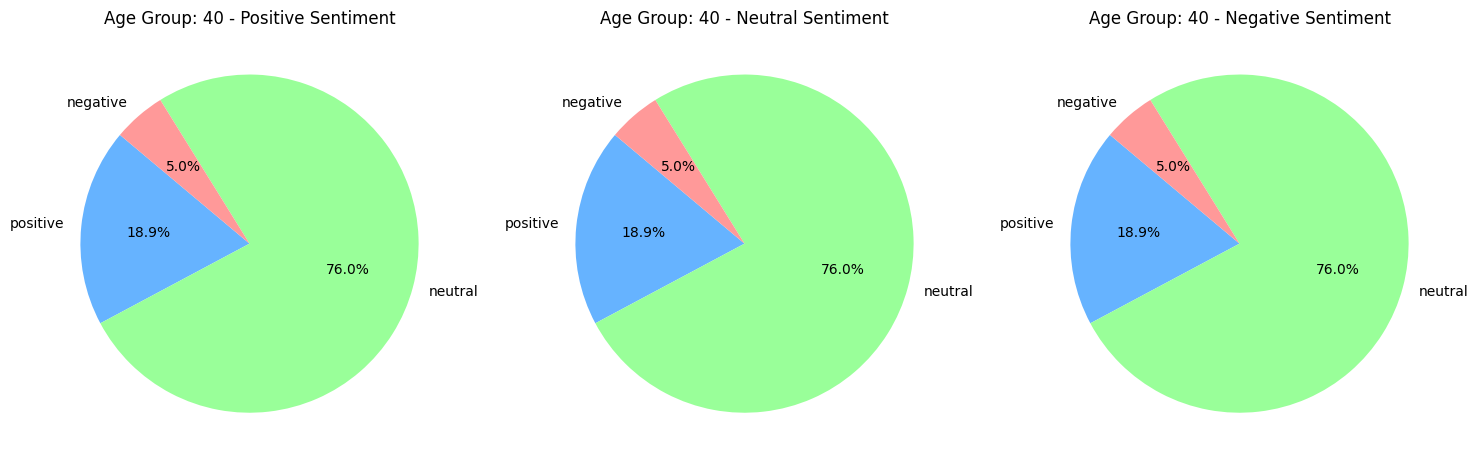

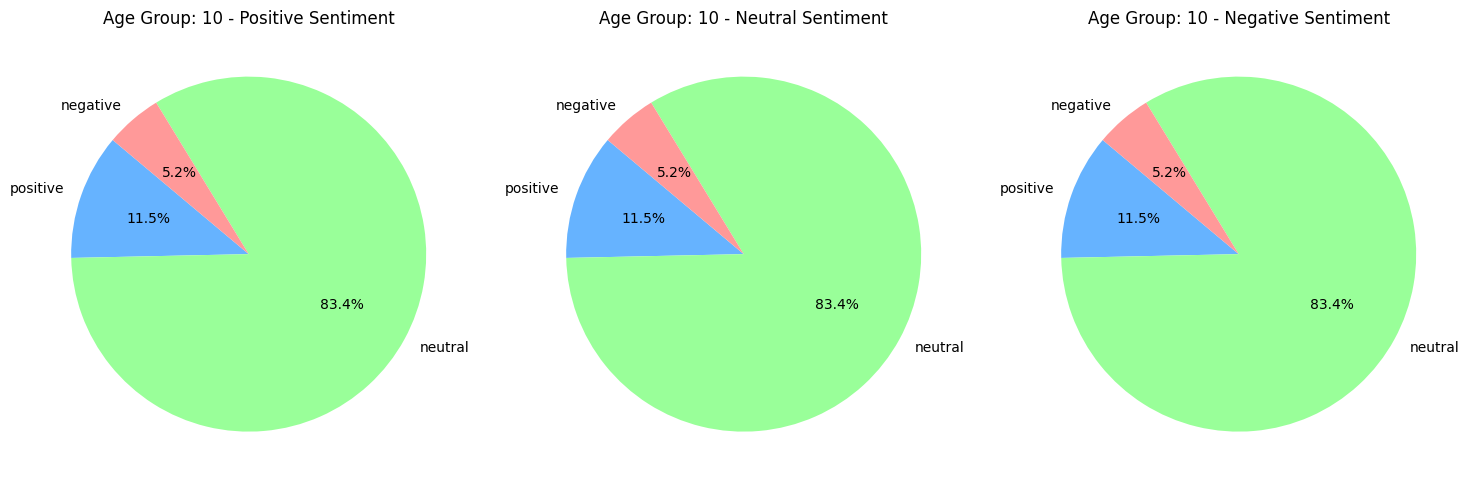

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize sentiment scores for each age group
def visualize_sentiment_scores_age_group(df, scores, labels, age_groups):
    # Create a DataFrame to store the sentiment scores and labels
    sentiment_df = pd.DataFrame(scores, columns=labels)
    sentiment_df["Text"] = df["Text"].tolist()
    sentiment_df["predicted_age"] = df["predicted_age"].tolist()

    # Plot sentiment scores for each age group
    unique_age_groups = df["predicted_age"].unique()
    for age_group in unique_age_groups:
        age_group_df = sentiment_df[sentiment_df["predicted_age"] == age_group]
        age_group_scores = age_group_df[labels].values[0]  # Assuming only one row per age group

        # Create subplots for positive, neutral, and negative sentiment scores
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        colors = ['#66b3ff', '#99ff99', '#ff9999']

        # Plot positive sentiment scores
        axs[0].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[0].set_title(f'Age Group: {age_group} - Positive Sentiment')

        # Plot neutral sentiment scores
        axs[1].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[1].set_title(f'Age Group: {age_group} - Neutral Sentiment')

        # Plot negative sentiment scores
        axs[2].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[2].set_title(f'Age Group: {age_group} - Negative Sentiment')

        plt.tight_layout()
        plt.show()

# Calculate unique age groups
unique_age_groups = predicted_data["predicted_age"].unique()

# Define labels for sentiment scores
labels = ['positive', 'neutral', 'negative']

# Call the function to visualize sentiment scores for each age group
visualize_sentiment_scores_age_group(predicted_data, scores, labels, unique_age_groups)


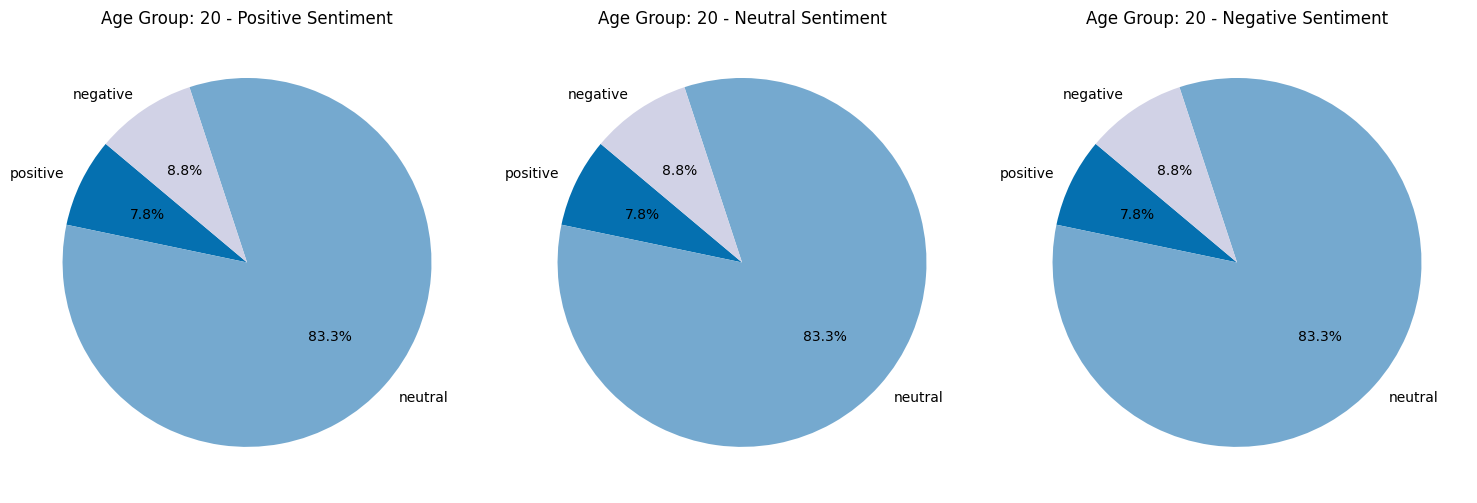

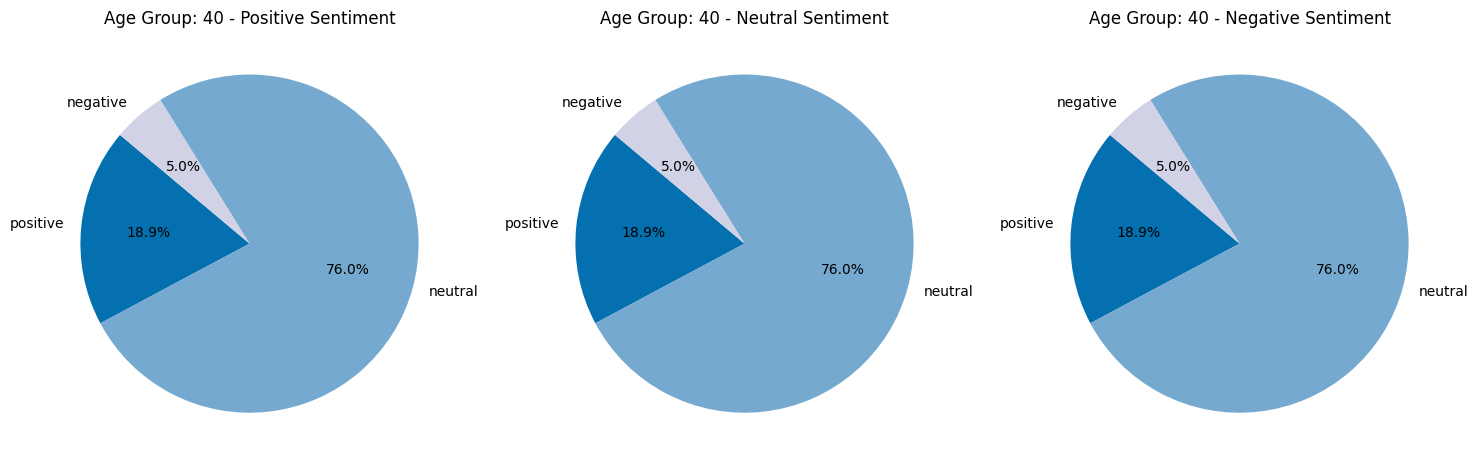

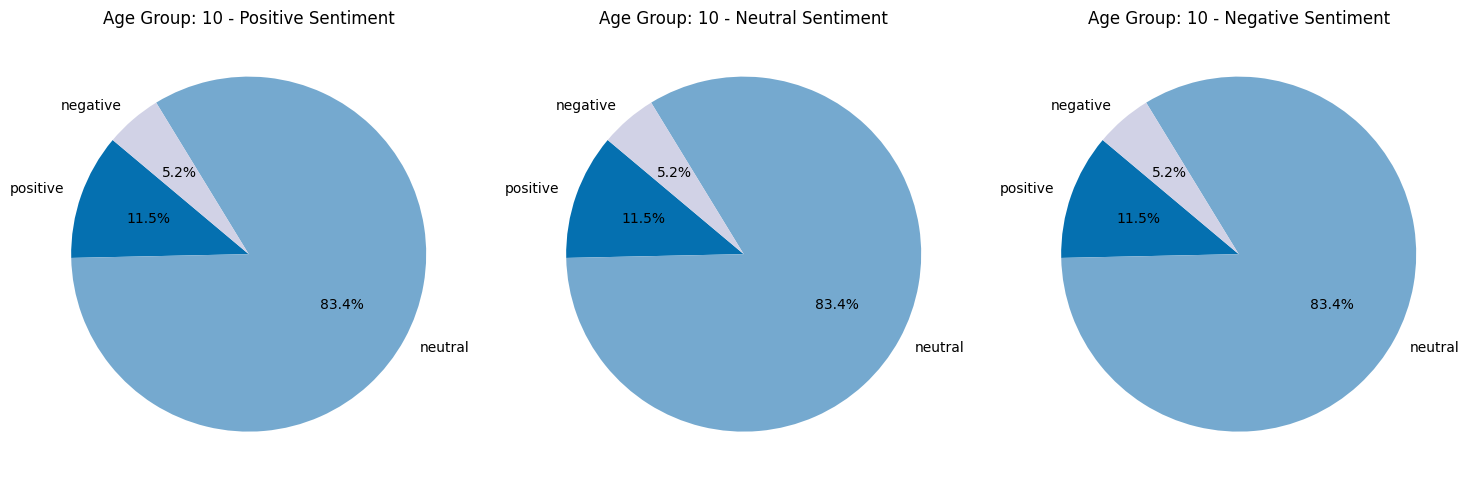

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize sentiment scores for each age group
def visualize_sentiment_scores_age_group(df, scores, labels, age_groups):
    # Create a DataFrame to store the sentiment scores and labels
    sentiment_df = pd.DataFrame(scores, columns=labels)
    sentiment_df["Text"] = df["Text"].tolist()
    sentiment_df["predicted_age"] = df["predicted_age"].tolist()

    # Define the color palette
    colors = sns.color_palette("PuBu_r", n_colors=len(labels))

    # Plot sentiment scores for each age group
    unique_age_groups = df["predicted_age"].unique()
    for age_group in unique_age_groups:
        age_group_df = sentiment_df[sentiment_df["predicted_age"] == age_group]
        age_group_scores = age_group_df[labels].values[0]  # Assuming only one row per age group

        # Create subplots for positive, neutral, and negative sentiment scores
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot positive sentiment scores
        axs[0].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[0].set_title(f'Age Group: {age_group} - Positive Sentiment')

        # Plot neutral sentiment scores
        axs[1].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[1].set_title(f'Age Group: {age_group} - Neutral Sentiment')

        # Plot negative sentiment scores
        axs[2].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[2].set_title(f'Age Group: {age_group} - Negative Sentiment')

        plt.tight_layout()
        plt.show()

# Calculate unique age groups
unique_age_groups = predicted_data["predicted_age"].unique()

# Define labels for sentiment scores
labels = ['positive', 'neutral', 'negative']

# Call the function to visualize sentiment scores for each age group
visualize_sentiment_scores_age_group(predicted_data, scores, labels, unique_age_groups)


# Save the plots as image files
for age_group in unique_age_groups:
    # Create a filename for the image
    filename = f"sentiment_plot_{age_group}.png"

    # Save the figure
    fig.savefig(filename)
    print(f"Plot saved as {filename}")

# Close the figures to free up memory
plt.close('all')



Plot saved as sentiment_plot_20.png


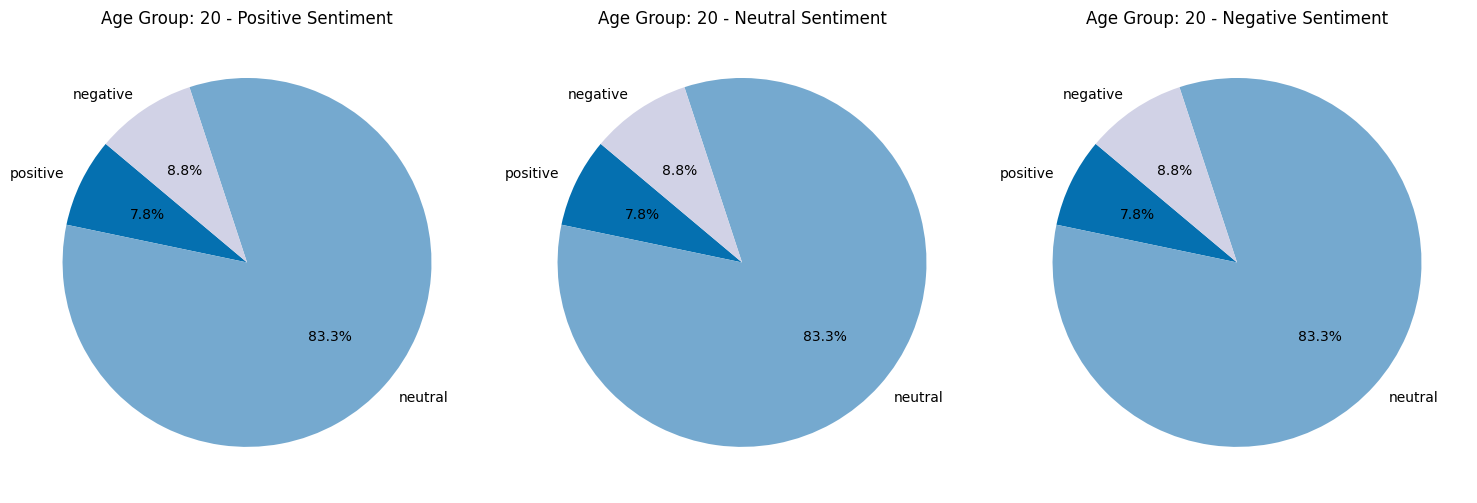

Plot saved as sentiment_plot_40.png


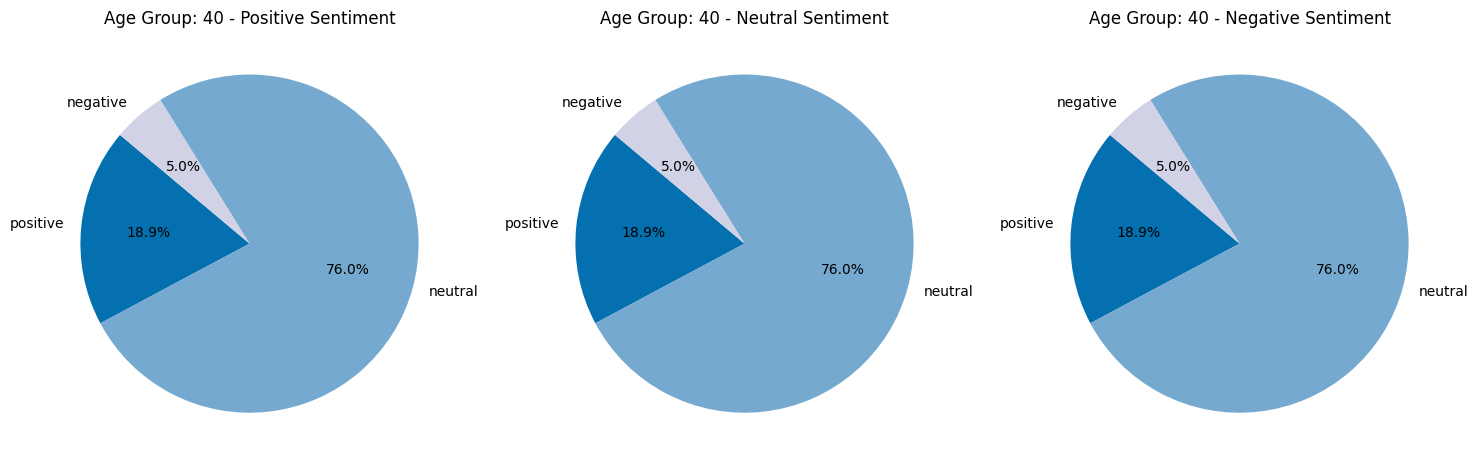

Plot saved as sentiment_plot_10.png


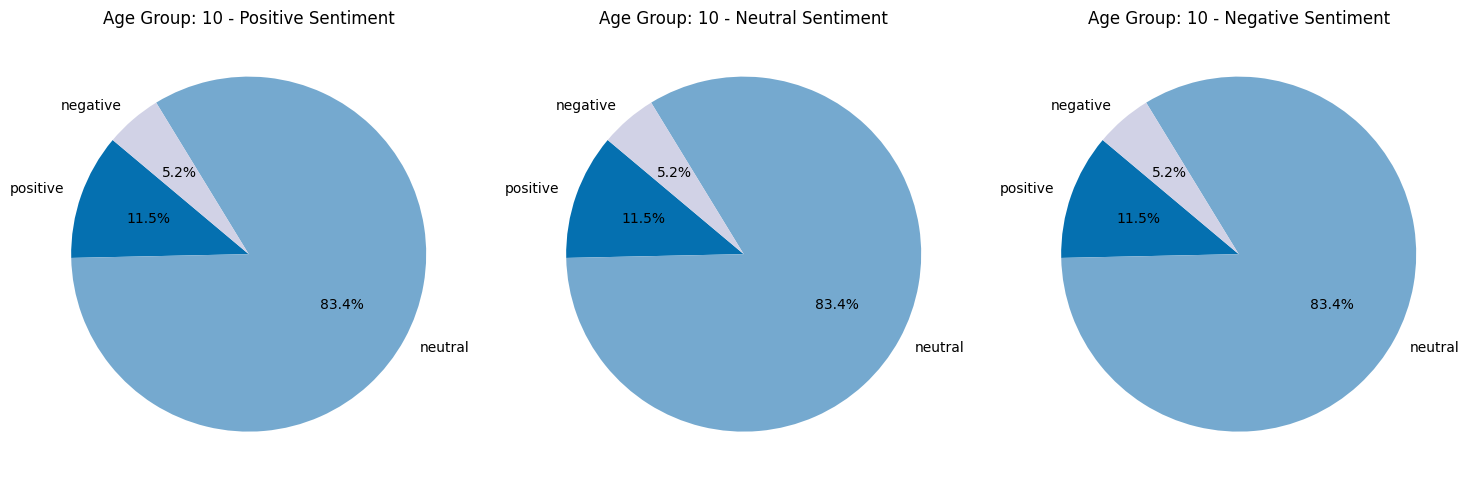

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize sentiment scores for each age group
def visualize_sentiment_scores_age_group(df, scores, labels, age_groups):
    # Create a DataFrame to store the sentiment scores and labels
    sentiment_df = pd.DataFrame(scores, columns=labels)
    sentiment_df["Text"] = df["Text"].tolist()
    sentiment_df["predicted_age"] = df["predicted_age"].tolist()

    # Define the color palette
    colors = sns.color_palette("PuBu_r", n_colors=len(labels))

    # Plot sentiment scores for each age group
    unique_age_groups = df["predicted_age"].unique()
    for age_group in unique_age_groups:
        age_group_df = sentiment_df[sentiment_df["predicted_age"] == age_group]
        age_group_scores = age_group_df[labels].values[0]  # Assuming only one row per age group

        # Create subplots for positive, neutral, and negative sentiment scores
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot positive sentiment scores
        axs[0].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[0].set_title(f'Age Group: {age_group} - Positive Sentiment')

        # Plot neutral sentiment scores
        axs[1].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[1].set_title(f'Age Group: {age_group} - Neutral Sentiment')

        # Plot negative sentiment scores
        axs[2].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[2].set_title(f'Age Group: {age_group} - Negative Sentiment')

        # Save the figure
        filename = f"sentiment_plot_{age_group}.png"
        fig.savefig(filename)
        print(f"Plot saved as {filename}")

        plt.tight_layout()
        plt.show()
        plt.close()

# Calculate unique age groups
unique_age_groups = predicted_data["predicted_age"].unique()

# Define labels for sentiment scores
labels = ['positive', 'neutral', 'negative']

# Call the function to visualize sentiment scores for each age group
visualize_sentiment_scores_age_group(predicted_data, scores, labels, unique_age_groups)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize sentiment scores for each age group
def visualize_sentiment_scores_age_group(df, scores, labels, age_groups):
    # Create a DataFrame to store the sentiment scores and labels
    sentiment_df = pd.DataFrame(scores, columns=labels)
    sentiment_df["Text"] = df["Text"].tolist()
    sentiment_df["predicted_age"] = df["predicted_age"].tolist()

    # Define the color palette
    colors = sns.color_palette("PuBu_r", n_colors=len(labels))

    # Plot sentiment scores for each age group
    unique_age_groups = df["predicted_age"].unique()
    for age_group in unique_age_groups:
        age_group_df = sentiment_df[sentiment_df["predicted_age"] == age_group]
        age_group_scores = age_group_df[labels].values[0]  # Assuming only one row per age group

        # Create subplots for positive, neutral, and negative sentiment scores
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot positive sentiment scores
        axs[0].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[0].set_title(f'Age Group: {age_group} - Positive Sentiment')

        # Plot neutral sentiment scores
        axs[1].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[1].set_title(f'Age Group: {age_group} - Neutral Sentiment')

        # Plot negative sentiment scores
        axs[2].pie(age_group_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[2].set_title(f'Age Group: {age_group} - Negative Sentiment')

        # Save the figure
        filename = f"sentiment_plot_{age_group}.png"
        fig.savefig(filename)
        print(f"Plot saved as {filename}")

        plt.tight_layout()
        plt.show()
        plt.close()

# Calculate unique age groups
unique_age_groups = predicted_data["predicted_age"].unique()

# Define labels for sentiment scores
labels = ['positive', 'neutral', 'negative']

# Call the function to visualize sentiment scores for each age group
visualize_sentiment_scores_age_group(predicted_data, scores, labels, unique_age_groups)
